In [1]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
from pyresample.bilinear import NumpyBilinearResampler
from pyresample import geometry
import dask.array as da
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from oceanmodes import baroclinic
plt.rcParams.update({'font.size': 14})

In [2]:
uvel_centered = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel_centered.zarr')
vvel_centered = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel_centered.zarr')

uvel_centered = uvel_centered.assign_coords(i=("i", uvel_centered.i)).isel(k=0)#.isel(time=slice(41,378))

vvel_centered = vvel_centered.assign_coords(i=("i", uvel_centered.i)).isel(k=0)#.isel(time=slice(41,378))

uvel_centered['time'] = uvel_centered['time']/ np.timedelta64(1, 's')
vvel_centered['time'] = vvel_centered['time']/ np.timedelta64(1, 's')


In [3]:
uvel_centered.U.isel(i=uvel_centered.U.i.size//2, j=uvel_centered.U.j.size//2).x.values#.item()

array(7.0104165, dtype=float32)

In [4]:

def target_area_def(ds_patch,variable_name):
    """Get a pyresample area_def for a given patch."""
    center_point = ds_patch.isel(i=ds_patch.i.size//2, j=ds_patch.j.size//2)
    center_lon, center_lat = center_point.x.values.item(), -center_point.y.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lat_0': center_lat, 'lon_0': center_lon, 'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 512#2160
    height = 512#2160

    # 512 x 512 km
    area_extent = (-270000., -270000., 270000., 270000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def



def resample_transposed(data, resampler):
    return np.transpose(resampler.resample(data), (2, 1, 0))

def ufunc_resample(data):
    target_def = target_area_def(data.isel(time=0),'U')
    source_def = geometry.SwathDefinition(lons=data.x.values, lats=-data.y.values)
    resampler = NumpyBilinearResampler(source_def, target_def, 30e3)
    resampled = xr.apply_ufunc(resample_transposed,data,resampler,input_core_dims=[['i','j'],['i','j']],output_core_dims=[['y1','x1']])
    return resampled



In [21]:
uvel_centered.U

,Array,Chunk
Bytes,18.68 GB,7.87 MB
Shape,"(1001, 2160, 2160)","(27, 270, 270)"
Count,12161 Tasks,2432 Chunks
Type,float32,numpy.ndarray


In [55]:
#dt=160
u_resampled = ufunc_resample(uvel_centered.U.isel(time=np.arange(0,1001,6)).load())#.isel(time=slice(168-dt,169+dt))
v_resampled = ufunc_resample(vvel_centered.V.isel(time=np.arange(0,1001,6)).load())#.isel(time=slice(168-dt,169+dt))

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


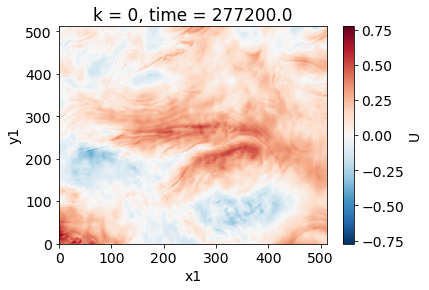

In [56]:
u_resampled.isel(time=1).plot()

In [57]:
u_resampled = u_resampled.assign_coords(x1=("x1", u_resampled.x1.values)).assign_coords(y1=("y1", u_resampled.y1.values)).isel(time=slice(1,2000))
v_resampled = v_resampled.assign_coords(x1=("x1", v_resampled.x1.values)).assign_coords(y1=("y1", v_resampled.y1.values)).isel(time=slice(1,2000))

In [58]:
u2_wavenumber = xrft.isotropic_power_spectrum(u_resampled, dim=['x1','y1'],window=True)
v2_wavenumber = xrft.isotropic_power_spectrum(v_resampled, dim=['x1','y1'],window=True)

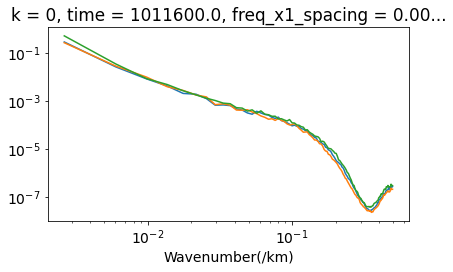

In [60]:
vel_wavenumber = (u2_wavenumber+v2_wavenumber)*0.5
vel_wavenumber.sel(time=vvel_centered.time[168],method='nearest').plot()
vel_wavenumber.sel(time=vvel_centered.time[168]-3600*40,method='nearest').plot()
vel_wavenumber.sel(time=vvel_centered.time[168]+3600*40,method='nearest').plot()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavenumber(/km)')
plt.tight_layout()

fig=plt.gcf()
fig.savefig('wavenumber.png')

In [61]:
with ProgressBar():
    u2_ps = xrft.power_spectrum(u_resampled, dim=['x1','y1','time'],window=True).compute()
    v2_ps = xrft.power_spectrum(v_resampled, dim=['x1','y1','time'],window=True).compute()
vel_ps = (u2_ps + v2_ps)*0.5

In [62]:
vel_ps

<xarray.DataArray (freq_time: 166, freq_y1: 512, freq_x1: 512)>
array([[[2.10622620e-04, 8.18520460e-05, 3.31497991e-04, ...,
         3.52395628e-04, 3.31497991e-04, 8.18520460e-05],
        [3.02367037e-04, 7.38448460e-04, 4.25966709e-04, ...,
         1.87306925e-04, 5.03288010e-05, 2.16567431e-04],
        [4.76587259e-04, 1.16604282e-03, 5.86870655e-04, ...,
         5.00293635e-04, 2.27289522e-04, 2.71956543e-04],
        ...,
        [4.69359687e-04, 1.79246054e-04, 1.03951371e-04, ...,
         1.03148542e-04, 1.47044832e-04, 4.31620446e-04],
        [4.76587259e-04, 2.71956543e-04, 2.27289522e-04, ...,
         1.49339202e-04, 5.86870655e-04, 1.16604282e-03],
        [3.02367037e-04, 2.16567431e-04, 5.03288010e-05, ...,
         1.00162574e-04, 4.25966709e-04, 7.38448460e-04]],

       [[6.73900696e-05, 2.03320309e-04, 5.35746764e-04, ...,
         1.79897397e-04, 2.65709892e-04, 1.06745760e-04],
        [1.26054785e-04, 2.01284682e-04, 2.61188876e-05, ...,
         5.04741440e-05, 1.51611335e-04, 2.34342268e-04],
        [1.62923566e-04, 5.65025095e-04, 2.02504083e-04, ...,
         6.92397207e-04, 3.07078162e-04, 3.30755753e-05],
...
        [2.89610731e-04, 3.37957700e-04, 5.92845079e-04, ...,
         3.43945096e-04, 4.88792257e-04, 4.07524238e-04],
        [8.69485942e-05, 1.48363166e-04, 3.53779054e-04, ...,
         2.58400260e-04, 7.06806020e-05, 2.93917747e-04],
        [1.61055437e-04, 2.76226354e-04, 2.33509454e-04, ...,
         5.08477623e-04, 6.58288138e-04, 6.14978649e-05]],

       [[6.73900696e-05, 1.06745760e-04, 2.65709892e-04, ...,
         4.59828385e-04, 5.35746764e-04, 2.03320309e-04],
        [2.18493938e-04, 7.75751818e-05, 2.49412009e-04, ...,
         2.99944439e-04, 1.20268364e-04, 3.93145358e-04],
        [2.45259257e-04, 4.62317830e-04, 4.27243756e-04, ...,
         4.49332684e-04, 1.81767952e-04, 2.84646671e-04],
        ...,
        [1.43080896e-04, 1.12642047e-04, 3.07360080e-04, ...,
         1.78745568e-04, 1.71520660e-04, 2.24925966e-04],
        [1.62923566e-04, 3.30755753e-05, 3.07078162e-04, ...,
         3.60047884e-05, 2.02504083e-04, 5.65025095e-04],
        [1.26054785e-04, 2.34342268e-04, 1.51611335e-04, ...,
         1.03060392e-04, 2.61188876e-05, 2.01284682e-04]]])
Coordinates:
    k                  int64 0
  * freq_time          (freq_time) float64 -2.315e-05 -2.287e-05 ... 2.287e-05
  * freq_y1            (freq_y1) float64 -0.5 -0.498 -0.4961 ... 0.4961 0.498
  * freq_x1            (freq_x1) float64 -0.5 -0.498 -0.4961 ... 0.4961 0.498
    freq_x1_spacing    float64 0.001953
    freq_y1_spacing    float64 0.001953
    freq_time_spacing  float64 2.789e-07

In [63]:
# Add the isotropic calculation (k,l) -> (k_r) (azimuthally average)
def azimuthal_avg(k, l, f, N, nfactor):
    """
    Takes the azimuthal average of a given field.
    """
    k = k.values; l = l.values
    kk, ll = np.meshgrid(k, l)
    K = np.sqrt(kk**2 + ll**2)
    nbins = int(N/nfactor)
    if k.max() > l.max():
        ki = np.linspace(0., l.max(), nbins)
    else:
        ki = np.linspace(0., k.max(), nbins)

    kidx = np.digitize(np.ravel(K), ki)
    area = np.bincount(kidx)

    kr = np.bincount(kidx, weights=K.ravel()) / area

    if f.ndim == 2:
        iso_f = np.ma.masked_invalid(np.bincount(kidx,
                                    weights=f.data.ravel())
                                    / area) * kr
    else:
        raise ValueError('The data has too many or few dimensions. '
                        'The input should only have the two dimensions '
                        'to take the azimuthal averaging over.')

    return kr, iso_f

def iso_spec_over_depth(ds):
    
    Zlen = len(ds.Z)
    klen = len(ds.freq_XC)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen , Zlen, int(klen/nfactor+1)])

    for j in range(0,omegalen):
        for i in range(0,Zlen):
            kr, ds_iso[j,i,:] = azimuthal_avg(ds.freq_XC, ds.freq_YC, ds.isel(Z=i, freq_time=j), 
                            len(ds.freq_XC), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'Z': ds.Z.values, 'kr':kr }, 
                             dims=['freq_time','Z', 'kr'])
    
    return ds_iso_xr

def iso_spec(ds):
    
    #Zlen = len(ds.Z)
    klen = len(ds.freq_x1)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen ,  int(klen/nfactor+1)])

    for j in range(0,omegalen):
            kr, ds_iso[j,:] = azimuthal_avg(ds.freq_x1, ds.freq_y1, ds.isel(freq_time=j), 
                            len(ds.freq_x1), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'kr':kr }, 
                             dims=['freq_time','kr'])
    
    return ds_iso_xr

In [64]:
ps_iso = iso_spec(vel_ps)
#

<ipython-input-63-a13b888bb314>:18: RuntimeWarning: invalid value encountered in true_divide
  kr = np.bincount(kidx, weights=K.ravel()) / area
<ipython-input-63-a13b888bb314>:21: RuntimeWarning: invalid value encountered in true_divide
  iso_f = np.ma.masked_invalid(np.bincount(kidx,


In [65]:
#Approximate radius of deformation
f = 2*2*np.pi/24/3600*np.sin(-45*np.pi/180)
omega_disp = np.sqrt(f**2*(1+(ps_iso.kr)**2*10**2))*3600

<ipython-input-66-35a2e5e8a878>:5: UserWarning: Log scale: values of z <= 0 have been masked
  cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso,lev,norm=LogNorm(), cmap='Blues')


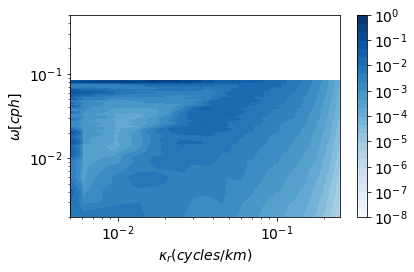

In [66]:
omega = ps_iso.freq_time*3600
kr    = ps_iso.kr
lev_exp = np.linspace(-8,0,25)
lev = np.power(10, lev_exp)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso,lev,norm=LogNorm(), cmap='Blues')
plt.colorbar(cs)
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.002, 0.5])
plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
fig=plt.gcf()
fig.savefig('wavenumber_freq.png')

In [47]:
np.sqrt(9.81*4000/f**2)/1000

2374.526804723843

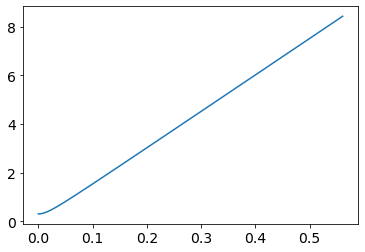

In [66]:
plt.plot(ps_iso.kr.values, omega_disp.values)

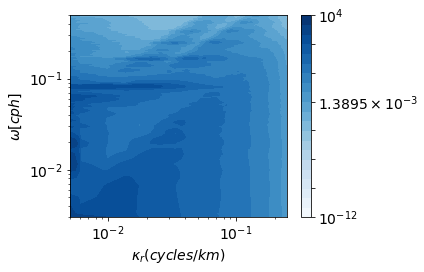

In [34]:
omega = ps_iso.freq_time*3600
kr    = ps_iso.kr
lev_exp = np.linspace(-12,4,22)
lev = np.power(10, lev_exp)
cs = plt.contourf(kr,omega,ps_iso,lev,norm=LogNorm(), cmap='Blues')
plt.colorbar(cs)
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.003, 0.5])
plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()

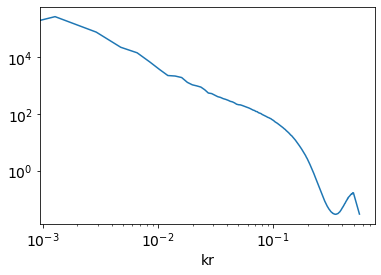

In [104]:
ps_iso.sum('freq_time').plot()
plt.xscale('log')
plt.yscale('log')

In [43]:
(ps_iso.freq_time*3600)[501]*2

<xarray.DataArray 'freq_time' ()>
array(0.002)
Coordinates:
    freq_time  float64 2.778e-07

In [81]:
0.001281*2

0.002562

In [32]:
ps_iso.kr

<xarray.DataArray 'kr' (kr: 129)>
array([0.      , 0.002653, 0.006041, 0.009854, 0.01368 , 0.017633, 0.021654,
       0.02555 , 0.029401, 0.033384, 0.037339, 0.041203, 0.045167, 0.049103,
       0.052959, 0.056915, 0.060858, 0.064781, 0.068763, 0.072643, 0.076468,
       0.080389, 0.084352, 0.088333, 0.092274, 0.096104, 0.100036, 0.104025,
       0.107887, 0.111794, 0.115788, 0.119724, 0.12356 , 0.127472, 0.131455,
       0.135418, 0.139331, 0.143196, 0.14707 , 0.151024, 0.154967, 0.158895,
       0.162809, 0.166727, 0.170628, 0.174516, 0.178457, 0.182438, 0.18634 ,
       0.190219, 0.194094, 0.198017, 0.202014, 0.205966, 0.209849, 0.213754,
       0.217663, 0.221566, 0.225495, 0.229451, 0.233381, 0.237288, 0.24122 ,
       0.245139, 0.24905 , 0.252984, 0.256914, 0.260831, 0.264744, 0.268658,
       0.272566, 0.276472, 0.280412, 0.284362, 0.28827 , 0.292146, 0.296061,
       0.300007, 0.303955, 0.307887, 0.311789, 0.315705, 0.319624, 0.323536,
       0.327467, 0.331404, 0.335323, 0.339225, 0.343128, 0.347036, 0.35098 ,
       0.35491 , 0.358844, 0.362767, 0.366667, 0.370572, 0.37449 , 0.378427,
       0.38237 , 0.386283, 0.390149, 0.394067, 0.398031, 0.401938, 0.405857,
       0.409789, 0.413684, 0.417598, 0.421549, 0.425492, 0.429426, 0.433331,
       0.437239, 0.441149, 0.445073, 0.449022, 0.452944, 0.45684 , 0.460758,
       0.464688, 0.468588, 0.472506, 0.476433, 0.480356, 0.484293, 0.488197,
       0.492096, 0.496027, 0.561075])
Coordinates:
  * kr       (kr) float64 0.0 0.002653 0.006041 0.009854 ... 0.4921 0.496 0.5611

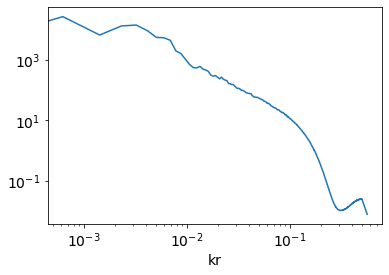

In [211]:
ps_iso.sum('freq_time').plot()
plt.xscale('log')
plt.yscale('log')